In [ ]:
import os

In [ ]:
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

In [ ]:
CHUNK_SIZE = 40960

In [ ]:
DATA_SOURCE_MAPPING = "eeg-brainwave-dataset-feeling-emotions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F93959%2F218459%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T131018Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db1d57ba1c8643b20674007061dc9924e4ca78f8ed0d1906703534272dbb25b62887d68e3429fe8900479f6bb80ac32443849b0c535b6a05557d762be23894840b5cc3c448551774b74f03079c466f1d136df110ec9d5f42e3d85dff747eb70b25bbec3bf2ad0069d2e29e267e6c213cb808fe553f707975b9a3987cd95377991fa07afb6f4de81185a44d7e1c1675a6e0a52761e8e10454d13bc0f7e585dc669b43af48605b1b104caa93629f29dd79620d44437e274f0c7a137b2ad471c0dad59ce2a896848ce4c09d7fd96568cb61c0bc27eecfd50c66ea30515daadaf24659d7133b66c6d6235aa5aee362f164cad77f388139479a230f1955bf9f36a441e"

EEG Brainwave Dataset: Feeling Emotions

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/content/emotions.csv')

In [3]:
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2547), int64(1), object(1)
memory usage: 1.7+ MB


In [5]:
data.describe()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,...,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,14.973575,27.741149,-106.252145,13.241057,24.502989,1.925367,-0.029532,8.383108,2.626523,0.325908,...,0.863605,89.219256,-46.054442,-46.054442,89.219256,-16.410581,97.560628,-51.982174,-51.982174,97.560628
std,12.338938,7.634671,228.759878,14.897553,5.549137,16.988641,2.808606,49.901845,18.158486,3.976784,...,314.198094,215.684064,110.429922,110.429922,215.684064,248.553421,186.899767,89.311855,89.311855,186.899767
min,-16.900000,-17.700000,-970.000000,-26.600000,-13.100000,-38.000000,-12.800000,-142.000000,-40.500000,-10.100000,...,-1120.000000,-327.000000,-424.000000,-424.000000,-327.000000,-994.000000,-118.000000,-391.000000,-391.000000,-118.000000
25%,7.120000,27.450000,-171.000000,4.625000,23.700000,-2.465000,-1.420000,-2.005000,-2.110000,-2.100000,...,-27.050000,-11.375000,-74.650000,-74.650000,-11.375000,-51.325000,-8.262500,-113.750000,-113.750000,-8.262500
50%,12.700000,30.100000,20.900000,15.800000,25.100000,-0.051400,0.287000,2.590000,0.461000,0.852000,...,90.250000,12.100000,-13.650000,-13.650000,12.100000,75.400000,11.800000,-20.300000,-20.300000,11.800000
75%,28.750000,31.450000,30.000000,27.250000,26.750000,3.025000,1.695000,9.555000,3.650000,3.135000,...,148.750000,71.675000,17.200000,17.200000,71.675000,138.500000,146.000000,3.607500,3.607500,146.000000
max,39.300000,35.300000,65.500000,39.300000,32.900000,108.000000,7.980000,402.000000,114.000000,9.530000,...,835.000000,821.000000,211.000000,211.000000,821.000000,345.000000,773.000000,94.400000,94.400000,773.000000


selecting all columns that start with fft_

In [6]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']

In [49]:
data = data.dropna()

In [51]:
target = data['label']
data1 = data.drop(['label'], axis=1)

In [52]:
data['label'].value_counts()

NEUTRAL     32
POSITIVE    30
NEGATIVE    24
Name: label, dtype: int64

In [53]:
target.value_counts()

NEUTRAL     32
POSITIVE    30
NEGATIVE    24
Name: label, dtype: int64

In [54]:
import numpy as np
nan_counts = data.isna().sum()

# Print the number of NaNs
print("Number of NaNs:", nan_counts)

Number of NaNs: # mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
label         0
Length: 2549, dtype: int64


In [55]:
scaler= StandardScaler()
data2= pd.DataFrame(scaler.fit_transform(data1))

In [56]:
data2

,0,1,2,3,4,5,6,7,8,9,...,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547
0,-0.840557,0.341732,-1.086999,0.157459,0.326659,-0.076253,0.199809,-0.485965,-0.060869,0.713557,...,0.235097,-0.306489,0.604398,0.604398,-0.306489,-0.803667,0.981860,-1.239064,-1.239064,0.981860
1,1.119257,0.709062,0.612946,0.842159,-0.304272,0.254695,0.674932,-0.113474,0.040010,-1.291420,...,0.413414,-0.524745,0.220925,0.220925,-0.524745,0.802943,-0.511225,0.229552,0.229552,-0.511225
2,-0.493658,0.223662,-1.349877,0.231299,-0.142033,4.684450,1.303936,1.637115,4.945479,0.431803,...,-1.712298,1.738502,-1.702818,-1.702818,1.738502,-1.014105,0.987242,-1.081390,-1.081390,0.987242
3,-0.007352,0.512278,-0.153782,0.439394,-0.033873,-0.176142,-0.060405,0.005611,-0.047191,-0.574458,...,-0.588616,0.978334,-1.793904,-1.793904,0.978334,0.600599,-0.591791,0.692774,0.692774,-0.591791
4,1.078732,0.472921,0.670779,0.942850,0.002180,1.960770,-2.121892,-0.109865,2.181272,1.309767,...,0.362192,-0.360120,0.766532,0.766532,-0.360120,0.547990,-0.619776,0.854615,0.854615,-0.619776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,-1.356042,-0.274856,0.458155,-2.487362,-0.574672,-0.174873,1.513605,-0.080796,-0.108744,0.665759,...,-0.011729,-0.498629,-0.029563,-0.029563,-0.498629,0.116188,-0.374903,0.598058,0.598058,-0.374903
82,1.970293,0.315494,0.620394,1.748379,-0.124006,1.115281,-0.796490,-0.244788,1.041394,0.125397,...,0.663121,-0.359187,0.281042,0.281042,-0.359187,0.762474,-0.443252,0.871508,0.871508,-0.443252
83,-1.377115,-0.392926,0.512351,-1.977193,-0.935204,-0.252598,-0.504452,-0.316359,-0.099625,0.607899,...,0.036932,-0.338201,0.325674,0.325674,-0.338201,-0.120959,-0.753246,0.167609,0.167609,-0.753246
84,1.013891,0.420446,0.617765,0.909286,-0.142033,-0.183087,-0.467011,-0.192663,-0.260348,-0.337987,...,0.252065,-0.372152,0.339428,0.339428,-0.372152,0.681537,-0.677362,0.746496,0.746496,-0.677362


In [57]:
from sklearn.preprocessing import LabelEncoder

In [58]:
enc = LabelEncoder()

In [59]:
y1 =pd.DataFrame(enc.fit_transform(target))

In [60]:
y1

,0
0,0
1,1
2,2
3,2
4,1
...,...
81,2
82,1
83,2
84,1


In [61]:
y1.value_counts()

1    32
2    30
0    24
dtype: int64

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data2, y1, train_size= 0.8)

In [63]:
from sklearn.neural_network import MLPClassifier

In [64]:
clf = MLPClassifier( solver ='lbfgs', alpha = 1e-5, hidden_layer_sizes =(128, 128), random_state=1)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(128, 128), random_state=1,
              solver='lbfgs')

In [65]:
from sklearn.metrics import accuracy_score

In [66]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test)
accuracy = clf.score(X_test_imputed, y_test)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8888888888888888


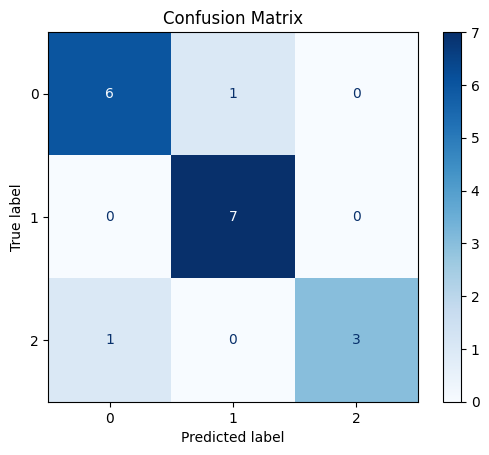

In [67]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = clf.predict(X_test_imputed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')

plt.show()

In [68]:
clr = classification_report(y_test, y_pred, target_names ={'Neutral','Positive', 'Negative'})

In [69]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

     Neutral       0.86      0.86      0.86         7
    Positive       0.88      1.00      0.93         7
    Negative       1.00      0.75      0.86         4

    accuracy                           0.89        18
   macro avg       0.91      0.87      0.88        18
weighted avg       0.90      0.89      0.89        18

